In [1]:
# camera calibration
from os import listdir
from scipy import misc
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


CAM_CAL_PATH = './camera_cal/'

cam_cal_imgs = []
for img_file in listdir(CAM_CAL_PATH):
    try:
        img = misc.imread(CAM_CAL_PATH + img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cam_cal_imgs.append(img)
    except IOError: pass

17 found.


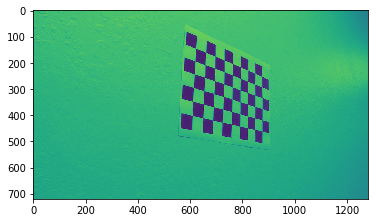

In [2]:
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = np.mgrid[0:6, 0:9].T.reshape(-1,2)

object_points = []
img_points = []
for img in cam_cal_imgs:
    plt.imshow(img)
    ret, corners = cv2.findChessboardCorners(img, (9, 6), None)
    if (ret):
        object_points.append(objp)
        img_points.append(corners)

print (len(img_points), 'found.')

In [3]:
img_size = (cam_cal_imgs[1].shape[1], cam_cal_imgs[1].shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, img_points, img_size,None,None)

In [4]:
print (mtx, dist)

[[ 143.08147127    0.          639.4956478 ]
 [   0.          817.84727475  359.49932344]
 [   0.            0.            1.        ]] [[ -1.08929527e-02   3.00019798e-05  -4.85444918e-05   1.57584130e-03
   -2.35174525e-08]]


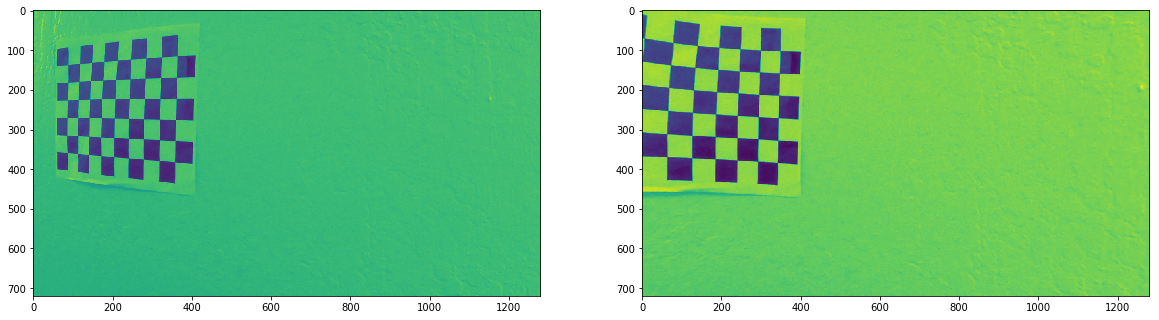

In [5]:
undist_test = cv2.undistort(cam_cal_imgs[10], mtx, dist, None, mtx)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(cam_cal_imgs[10])
plt.subplot(1,2,2)
plt.imshow(undist_test)


In [6]:
# loading the test images
TEST_PATH = './test_images/'

test_img = []
for img_file in listdir(TEST_PATH):
    try:
        img = misc.imread(TEST_PATH + img_file)
        test_img.append(img)
    except IOError: pass



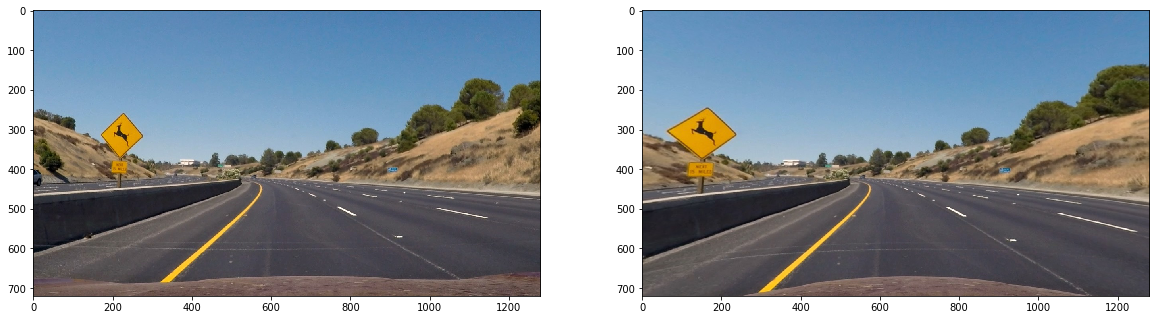

In [7]:
n = 3
undist_test = cv2.undistort(test_img[n], mtx, dist, None, mtx)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(test_img[n])
plt.subplot(1,2,2)
plt.imshow(undist_test)


In [8]:
# the pipeline magic
###############

def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)
    

def gradient_transform_x(image, ksize=5, thresh=(0,255)):
    img = np.copy(image)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)    
    sobelx = np.absolute(sobelx / np.max(sobelx) * 255)
    grads = np.zeros(img.shape)
    grads[(sobelx > thresh[0]) & (sobelx < thresh[1])] = 1
    return grads

def gradient_transform_y(image, ksize=5, thresh=(0,255)):
    img = np.copy(image)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)    
    sobely = np.absolute(sobely / np.max(sobely) * 255)
    grads = np.zeros(img.shape)
    grads[(sobely > thresh[0]) & (sobely < thresh[1])] = 1
    return grads

def gradient_transform_direction(image, ksize=5, thresh=(0 , 3.14)):
    img = np.copy(image)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
    grad_direction = np.arctan2(sobely, sobelx)
    grad_direction = np.absolute(grad_direction)
    
    grads = np.zeros(grad_direction.shape)
    grads[(grad_direction > thresh[0]) & (grad_direction < thresh[1])] = 1
    return grads

def warp(img, M):
    size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, size, flags=cv2.INTER_LINEAR)


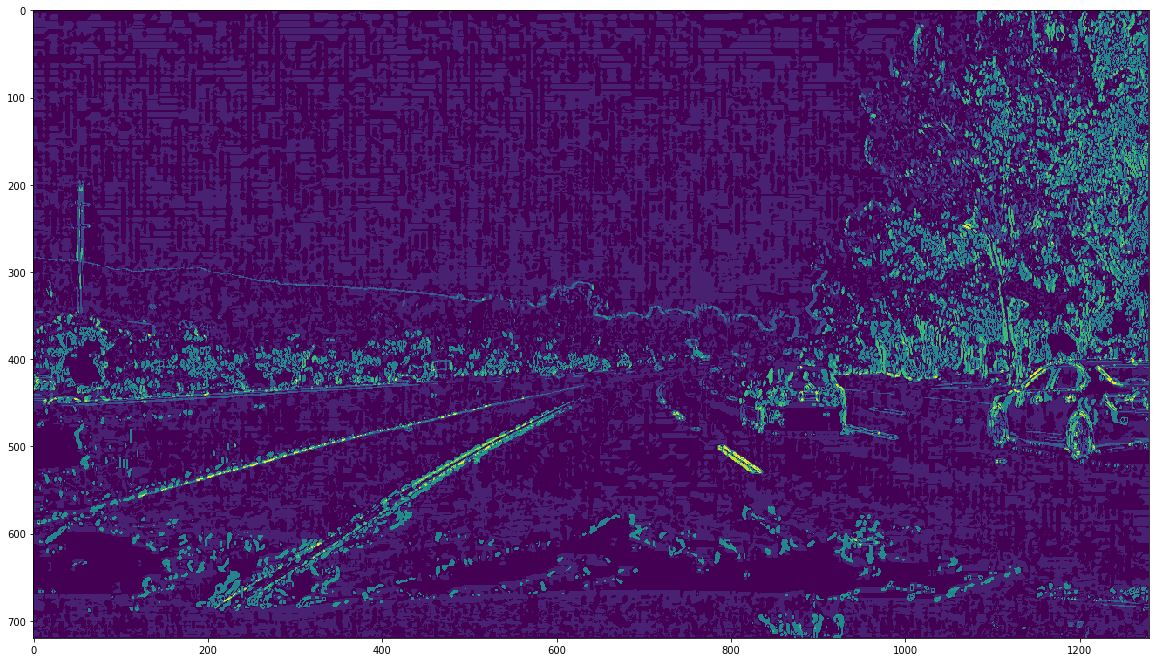

In [9]:
def gradient_transform_wrapper(image):
    img = np.copy(image)
    
    l_chan = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    gx = gradient_transform_x(l_chan, ksize = 7, thresh=(30, 150))
    gy = gradient_transform_y(l_chan, ksize = 7, thresh=(30, 150))
    gd = gradient_transform_direction(l_chan, ksize=7, thresh=(1.5,2.3)) 
    
    combo_hls = np.zeros(l_chan.shape)
    combo_hls[(gx == 1)] += 10
    combo_hls[(gx == 1)] += 10
    
    combo_hls[(gd == 1)] += 4
    
    bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gx = gradient_transform_x(bw, ksize = 7, thresh=(30, 150))
    gy = gradient_transform_y(bw, ksize = 7, thresh=(70, 150))
    #gd = gradient_transform_direction(img, ksize=7, thresh=(1.7,2.4)  
    combo_bw = np.zeros(bw.shape)
    #combo_bw[(gy == 1) | (gx == 1)] = 1                                      
    
    combo_hls[(gy == 1)] +=10
    combo_hls[(gx == 1)] +=10
    return combo_hls
    
    #combo = np.zeros(bw.shape)
    #combo[(combo_bw == 1) | (combo_hls == 1)] = 1
    
    
    return combo

def grad3d(image):
    out = gradient_transform_wrapper(image) * 254
    img = np.zeros((image.shape[0],image.shape[1],3 ))
    img[:,:,0] = out
    img[:,:,1] = out
    img[:,:,2] = out
    return np.concatenate((image,img), axis=1)

from moviepy.editor import VideoFileClip

INPUT_VIDEO = './project_video.mp4'

def write_video(input_f, output_f, f):
    clip = VideoFileClip(input_f) #.subclip(35,44)
    transformed = clip.fl_image(f)
    transformed.write_videofile(output_f, audio=False)
 

INPUT_VIDEO = './project_video.mp4'

plt.figure(figsize=(20,40))

img = VideoFileClip(INPUT_VIDEO).get_frame(42)

plt.imshow(gradient_transform_wrapper(img))
   

In [10]:
misc.imsave('calib.png', undistort(test_img[0]))


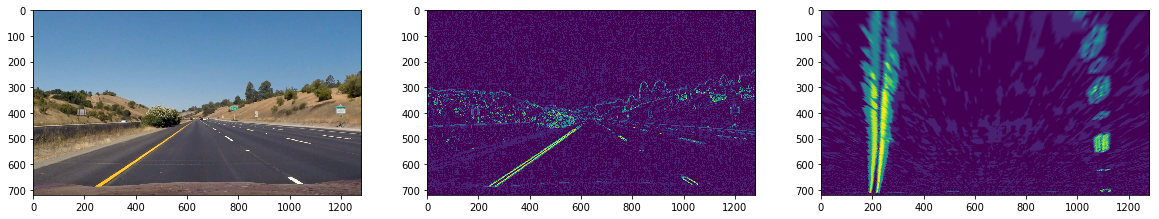

In [11]:
n = 0
src = np.float32([[205, 720]     #720
                 ,[535, 490]
                 ,[750, 490]     #490
                 ,[1101, 720]])

dst = np.float32([[205, 720]
                 ,[205, 490]
                 ,[1101, 490]
                 ,[1101, 720]])

M = cv2.getPerspectiveTransform(src, dst)
M_INV = cv2.getPerspectiveTransform(dst, src)

warped = warp(gradient_transform_wrapper(test_img[n]), M)
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(test_img[n])
plt.subplot(1,3,2)
plt.imshow(gradient_transform_wrapper(test_img[n]))
plt.subplot(1,3,3)
plt.imshow(warped)

In [12]:
def birds_eye(image, M):
    img = np.copy(image)
    img = undistort(img)
    img = gradient_transform_wrapper(img)
    img = warp(img, M)
    return img


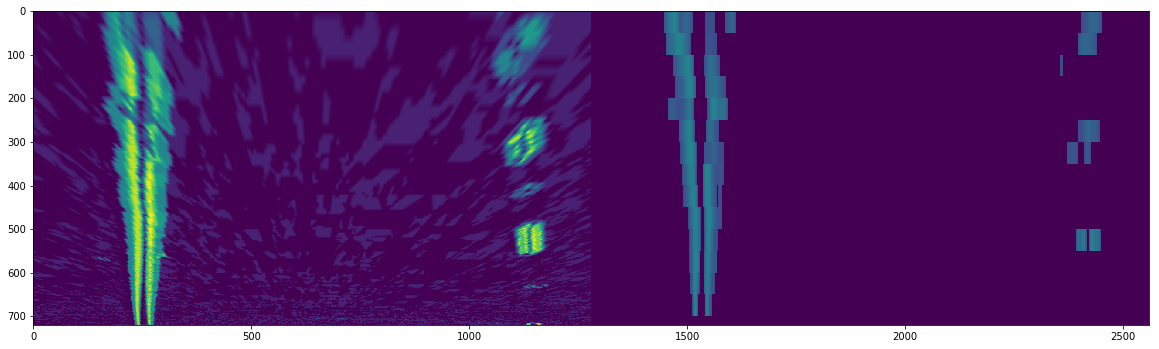

In [13]:
# histogram from birds eye img
from math import *

def hist_slide(data, wsize=50, thresh=0.5):
    out = np.zeros(data.shape)
    
    i = 0
    while i+wsize < data.shape[0]:
        start_y = i
        end_y = i + wsize
        
        window_hist = np.sum(data[start_y:end_y], axis=0)
        window_hist = window_hist / np.max(window_hist)

        window_hist[window_hist < thresh] = 0
        out[start_y:end_y] = window_hist
        
        i+= wsize

    return out
     


def test_frame(image):
    bird = birds_eye(image, M)
    hist = hist_slide(bird) 
    
    stacked = np.concatenate((bird, hist * 20), axis = 1)
    return stacked
    return np.stack((stacked,stacked,stacked), axis = 2)

def write_video(input_f, output_f, f):
    clip = VideoFileClip(input_f).subclip(30,45)
    transformed = clip.fl_image(f)
    transformed.write_videofile(output_f, audio=False)
 

INPUT_VIDEO = './project_video.mp4'
#write_video(INPUT_VIDEO, 'bird_test.mp4', test_frame)

plt.figure(figsize=(20,40))
img = VideoFileClip(INPUT_VIDEO).get_frame(16)
d = test_frame(img)
plt.imshow(d)

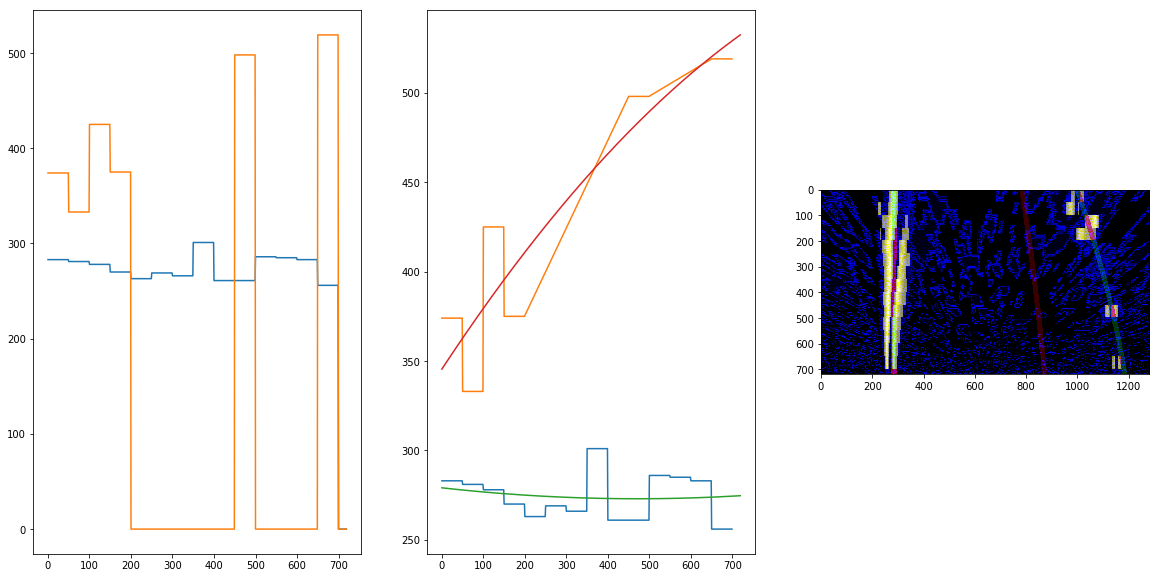

In [14]:
from moviepy.editor import VideoFileClip

INPUT_VIDEO = './project_video.mp4'

def fit_line_on_hist(p, degree=2, vis=False, plot=False, top_crop=0, x_transform = 1, y_transform = 1):
    y = np.argmax(p, axis=0)
    x = np.arange(len(y))
    y_mean = np.mean(y)
    y_std = np.std(y)
    
    xx = []
    yy = []
    for i in range(top_crop, len(y)-top_crop):
        if y[i] != 0 and abs(y[i] - y_mean) < y_std*4:
            xx.append(x[i])
            yy.append(y[i])

    xx = np.array(xx)
    yy = np.array(yy)
    
    # getting the average difference between the curve points
    avg_dist = np.abs(np.ediff1d(yy[np.where(yy != 0)]))
    avg_dist = np.mean(avg_dist[np.where(avg_dist != 0)])
    #print('avg_dist', avg_dist)
    
    # filtering the too large distances
    xxx = []
    yyy = []
    xx = xx[::-1]
    yy = yy[::-1]
    last_y = yy[0]
    for i in range(len(xx)):
        if abs(last_y - yy[i]) > 300 : continue
        last_y = yy[i]
        xxx.append(xx[i])
        yyy.append(yy[i])
    
    xx = np.array(xxx[::-1])
    yy = np.array(yyy[::-1])
    
    if plot:
        plt.subplot(1,3,1)
        plt.plot(x,y)
        plt.subplot(1,3,2)
        plt.plot(xx,yy)
            
    coeffs = np.polyfit(xx * x_transform, yy * y_transform, degree)
        
    return coeffs

def get_lane_curvatures(warped, length, plot = False):
    (coeff_l, coeff_r) = get_lane_coeffs(warped, length, plot=plot)
    x = np.arange(length)
    curve_l = coeff_l[0] * x**2 + coeff_l[1] * x + coeff_l[2]
    curve_r = coeff_r[0] * x**2 + coeff_r[1] * x + coeff_r[2]
    
    if plot:
        plt.subplot(1,3,2)
        plt.plot(curve_l)
        plt.plot(curve_r)
    return (curve_l, curve_r)

def get_lane_coeffs(warped, length, plot = False, x_transform = 1, y_transform = 1):
    lane_data = np.copy(warped)
    mid = int(lane_data.shape[1] / 2)
    left = hist_slide(lane_data)[:,:mid].T
    right = hist_slide(lane_data)[:,mid:].T

    coeff_l = fit_line_on_hist(left, plot=plot, x_transform=x_transform, y_transform=y_transform)
    coeff_r = fit_line_on_hist(right, plot=plot, x_transform=x_transform, y_transform=y_transform)
    return (coeff_l, coeff_r)

def draw_curve_on_warped(warped, plot=False):
    lane_data = np.copy(warped)
    cropped = np.copy(lane_data)
    mid = int(lane_data.shape[1] / 2)

    lane_data = lane_data / np.max(lane_data) * 255
    rgb = np.zeros((warped.shape[0], warped.shape[1], 3))
    rgb[:,:,0] = hist_slide(lane_data)
    rgb[:,:,1] = hist_slide(lane_data)
    rgb[:,:,2] = lane_data
    curve_l, curve_r = get_lane_curvatures(cropped, lane_data.shape[0], plot=plot)
        
    curve_m = curve_l + curve_r / 2
    
    for i in range(len(curve_l)):
        rgb[i,int(curve_l[i]) : int(curve_l[i] + 20),0] = 100
        rgb[i,int(curve_r[i]) + mid : int(curve_r[i]) + mid + 20,1] = 200
        rgb[i,int(curve_m[i] + mid/2) : int(curve_m[i] + mid/2 + 20),0] = 200
    
    
    
    return np.float32(rgb)
    
def bird_curves_frame(img, plot=False):
    return draw_curve_on_warped(birds_eye(img, M), plot=plot)


def write_video(input_f, output_f, f):
    clip = VideoFileClip(input_f).subclip(0,10)
    transformed = clip.fl_image(f)
    transformed.write_videofile(output_f, audio=False)

#write_video(INPUT_VIDEO, 'curves_on_bird.mp4', bird_curves_frame)
    
img = VideoFileClip(INPUT_VIDEO).get_frame(13)
plt.figure(figsize=(20,10))

im = bird_curves_frame(img, plot=True)
plt.subplot(1,3,3)
plt.imshow(im)


(720, 1280, 3)


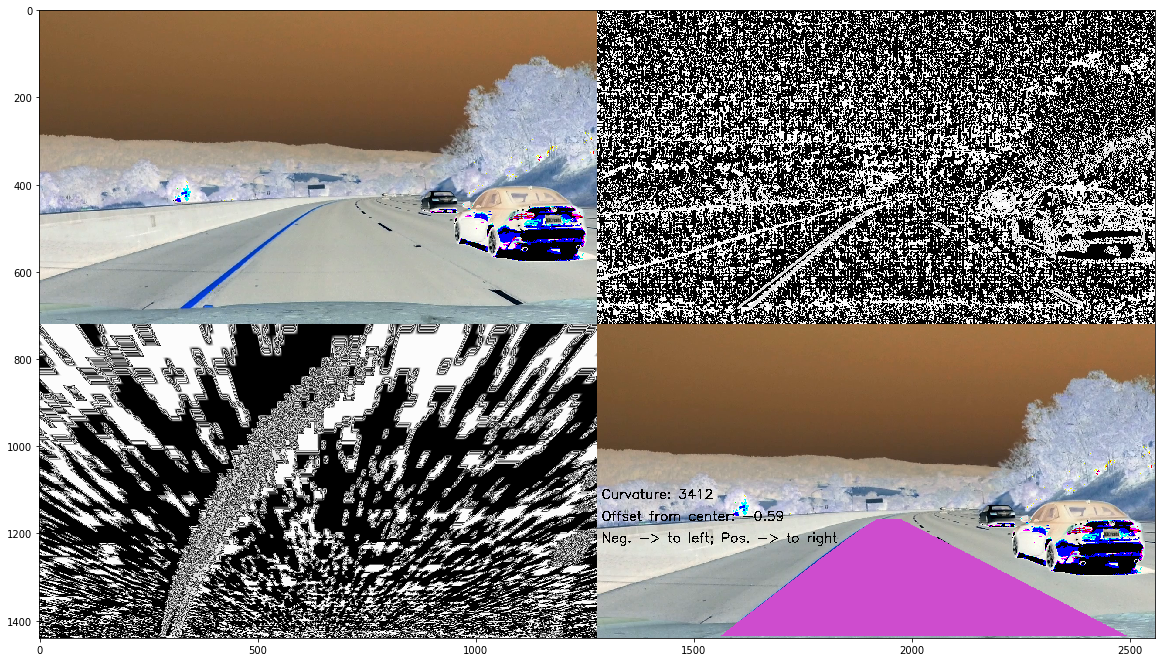

In [29]:
import cv2
from collections import deque

l_list = []
r_list = []
p_list = []

curvature_list = deque(maxlen=30)

def highlight_lane(image):
    img = np.copy(image)  
    # getting the lane curve coefficients
    bird = birds_eye(img, M)
    coeff_l, coeff_r = get_lane_coeffs(bird, bird.shape[0], x_transform=1, y_transform=1)
    coeff_middle = (coeff_l + coeff_r) / 2
    # making some outlier filtering
        
    l_list.append(coeff_l)
    r_list.append(coeff_r)

    # some smoothing
    coeff_l = np.mean(np.array(l_list[-10:]), axis=0)
    coeff_r = np.mean(np.array(r_list[-10:]), axis=0) 
  
    # generating the lane curves
    x = np.arange(bird.shape[0])  
    curve_l = coeff_l[0] * x**2 + coeff_l[1] * x + coeff_l[2]
    curve_r = coeff_r[0] * x**2 + coeff_r[1] * x + coeff_r[2]
    
    # draving the lanes in birds-eye perspective
    mid = int(bird.shape[1] / 2)
    lanes = np.zeros(bird.shape)
    for i in range(bird.shape[0]):
        lx = int(curve_l[i])
        rx = int(curve_r[i] + mid)
        lanes[i, lx : rx ] = 1

    # curvatures and the offset    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #coeff_l2, coeff_r2 = get_lane_coeffs(bird, bird.shape[0], x_transform=xm_per_pix, y_transform=ym_per_pix)
    coeff_middle = (coeff_l + coeff_r) / 2
    
    curvature = (1 + (2 * coeff_middle[0] * bird.shape[0] + coeff_middle[1])**2)**1.5 / abs(2*coeff_middle[0])
    curvature_list.append(curvature)
    
    #to_left_edge = abs(lanes.shape[1] / 2 - np.argmax(lanes[-1]))
    #to_right_edge = abs(lanes.shape[1] / 2 - np.argmax(lanes[::-1][-1]))
    to_left = image.shape[0] - np.argmax(lanes[-1])
    to_right = image.shape[0] - np.argmax(lanes[-1][::-1])
    
    #offset = (to_left_edge - to_right_edge) * xm_per_pix
    offset =  (to_left - to_right) * xm_per_pix / 2
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,'Curvature: {}'.format(int(sum(curvature_list) / len(curvature_list))),(10,400), font, 1,(255,255,255),2)
    cv2.putText(img,'Offset from center: {}'.format(int(offset*100)/100),(10,450), font, 1,(255,255,255),2)
    cv2.putText(img,'Neg. -> to left; Pos. -> to right'.format(int(offset*100)/100),(10,500), font, 1,(255,255,255),2)

    
        
    # warping the birds-eye lanes into perspective
    perspective = warp(lanes, M_INV)
    

    img[:,:,0][perspective == 1] = 50
    img[:,:,1][perspective == 1] = 180
    img[:,:,2][perspective == 1] = 50
    return img
  
    
def test_frame(image):
    img = np.copy(image)
    grad = gradient_transform_wrapper(image)
    bird = birds_eye(image, M)
    lane_curves = highlight_lane(img)

    up = np.concatenate((img, np.stack((grad,grad,grad), axis=2)), axis=1)
    down = np.concatenate((np.stack((bird,bird,bird), axis=2), lane_curves), axis=1)
    out = np.concatenate((up, down), axis=0)
    return out
    #return misc.imresize(np.uint8(out), (360, 640))
    
img = VideoFileClip(INPUT_VIDEO).get_frame(30)
print (img.shape)
plt.figure(figsize=(20,20))
plt.imshow(test_frame(img))



In [ ]:
from moviepy.editor import VideoFileClip

INPUT_VIDEO = './project_video.mp4'
OUTPUT_VIDEO = './new_out_video.mp4'

def write_video(input_f, output_f, f):
    clip = VideoFileClip(input_f)
    #clip = clip.subclip(32,39)
    transformed = clip.fl_image(f)
    transformed.write_videofile(output_f, audio=False)
 


write_video(INPUT_VIDEO, OUTPUT_VIDEO, highlight_lane)

[MoviePy] >>>> Building video ./new_out_video.mp4
[MoviePy] Writing video ./new_out_video.mp4



  3%|▎         | 33/1261 [00:11<07:57,  2.57it/s]

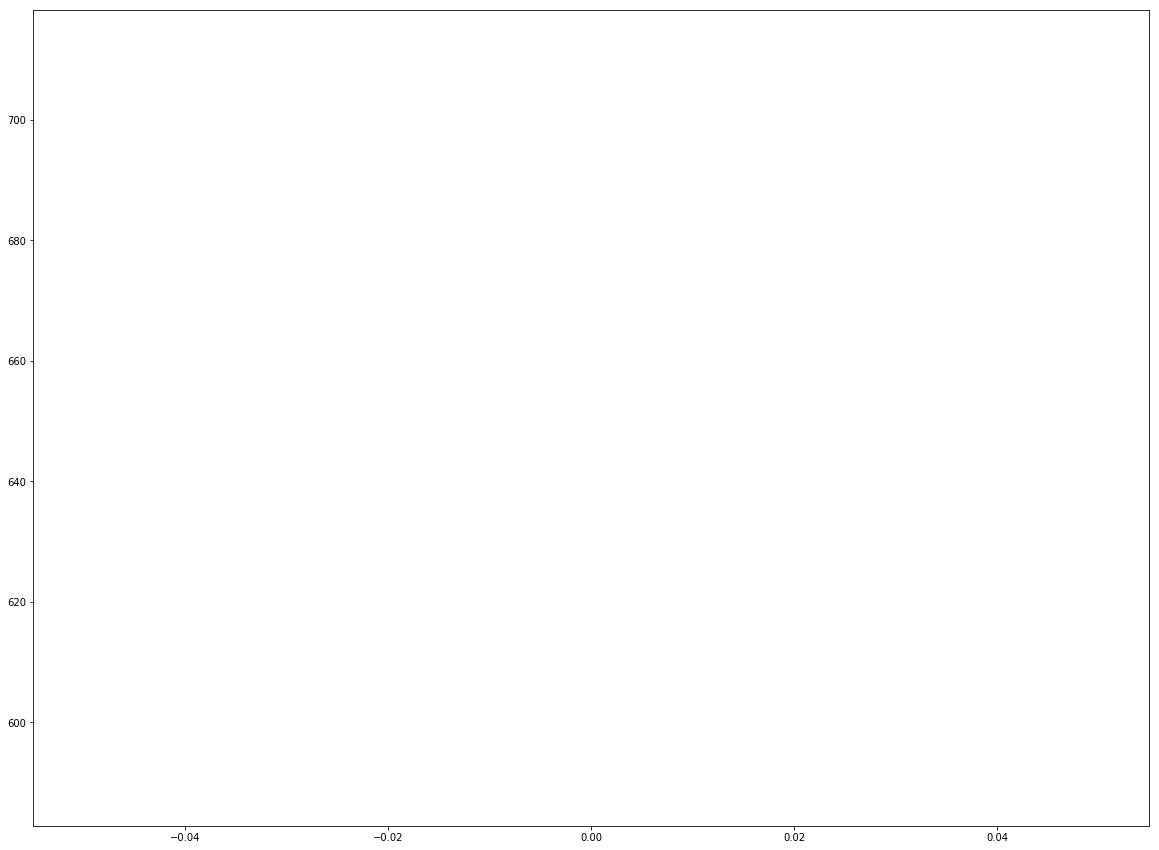

In [384]:
l = np.array(l_list)
r = np.array(r_list)
plt.figure(figsize=(20,15))
plt.plot(l[:,2])
plt.plot(r[:,2])
